In [68]:
import numpy as np  
import matplotlib.pyplot as plt
from numba import njit, prange

In [ ]:


height = 100
width = 100


# connect every cell to its neighbors, with wrap-around on y axis



In [139]:
def make_nbs(height, width, eta):

    all_nbs = []

    for i in range(height):
        for j in range(width):
            nbs = []
            if np.random.rand() < eta:
                nbs.append(((i + 1) % height, j))
            if np.random.rand() < eta:
                nbs.append(((i - 1) % height, j))

            if j+1 < width:
                nbs.append((i, (j + 1)))
            if j-1 >= 0:
                nbs.append((i, (j - 1)))

            all_nbs.append(np.array(nbs))

    return all_nbs
    

@njit(parallel=True)
def step(cells, all_nbs, tau, delta):
    alt_cells = np.zeros(len(cells))

    for i in prange(len(cells)):
        # waiting
        if cells[i] > 0:
            alt_cells[i] = cells[i] - 1
            continue

        # active
        if cells[i] == -1:
            alt_cells[i] = tau
            continue
        
        # inactive

        nbs = all_nbs[i]
        # nb_cells = cells[nbs[:,0], nbs[:,1]]
        nb_cells = cells[nbs[:,0] * width + nbs[:,1]]
        n_active = np.sum(nb_cells == -1)

        if n_active > 0 and np.random.rand() > delta:
            alt_cells[i] = -1


    return alt_cells

def plot_cells(cells):
    plt.imshow(cells.reshape(height, width), cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title('Cell States')
    plt.show()


@njit
def main(all_nbs, tau, delta):
    cells = np.zeros(len(all_nbs))
    N_steps = 200
    old_cells = np.zeros((N_steps, len(cells)))

    old_cells[0] = cells.copy()
    # make leftmost column active
    for i in range(height):
        cells[i * width] = -1

    for i in prange(N_steps):
        cells = step(cells, all_nbs, tau, delta)
        old_cells[i] = cells.copy()

    return old_cells




In [148]:
eta = 0.3
delta = 0.1
tau = 40

all_nbs = make_nbs(height, width, eta)
old_cells = main(all_nbs, tau, delta)


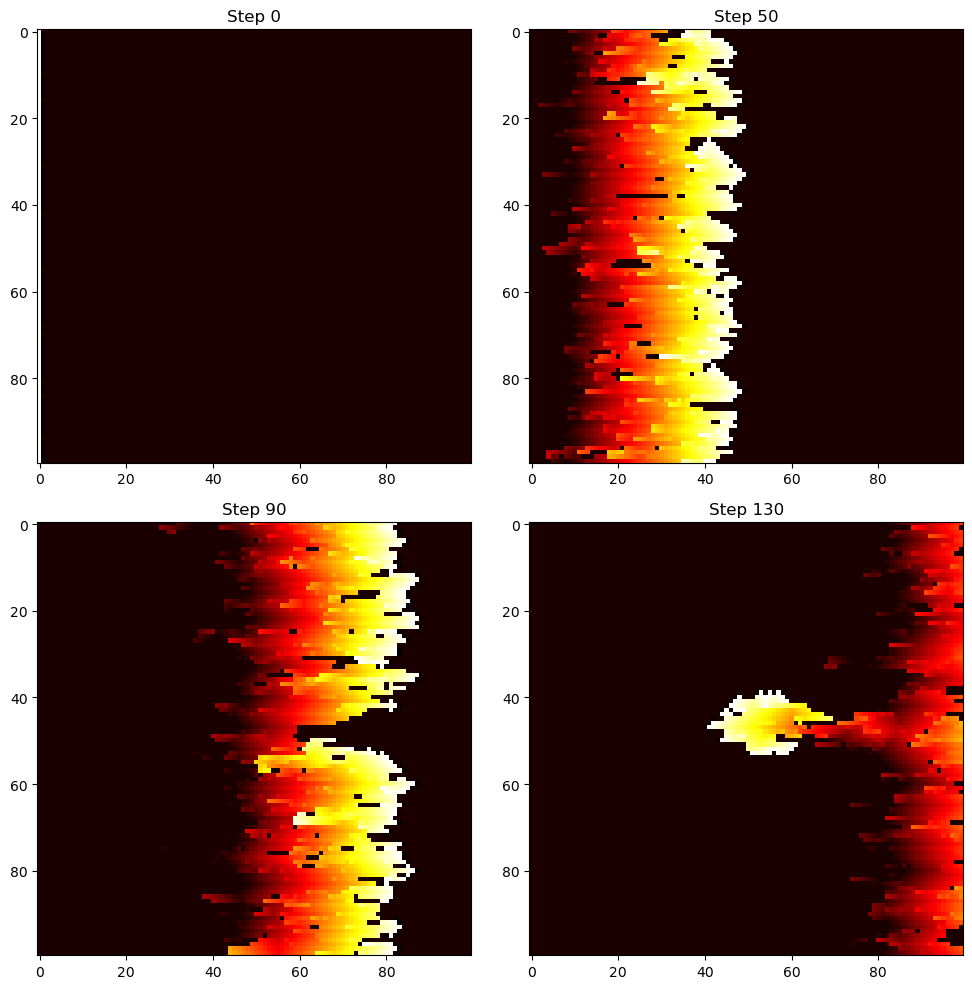

In [149]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
ploti = 0
for i in [0, 50, 90, 130]:
    ax = axs[ploti // 2, ploti % 2]
    ploti += 1
    ax.imshow(old_cells[i].reshape(height, width), cmap='hot', interpolation='nearest')
    ax.set_title(f'Step {i}')

plt.tight_layout()